In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [55]:
btc_df = pd.read_csv('../Data/btc_final_df.csv')

In [56]:
btc_df.columns

Index(['timestamp', 'btc_exchange_netflow_usd', 'active_sending_addresses',
       'active_receiving_addresses', 'onchain_volume_usd', 'open', 'low',
       'high', 'close', 'mint_reward_usd', 'total_fee_usd',
       'transaction_count', 'exchange_to_wallet_usd', 'wallet_to_exchange_usd',
       'RV_MA_1hr', 'RV_MA_3hr', 'RV_MA_12hr', 'hourly_return', 'vol_future',
       'whale_net_usd', 'whale_net_usd_24h', 'whale_burst_flag',
       'etow_usd_log', 'etow_coins_log', 'whale_txn_count_log', 'wtoe_usd_log',
       'wtoe_coins_log', 'eth_to_btc_spill'],
      dtype='object')

### General EDA 
1) Corrrelation heatmap
2) Distribution of Feature
3) Correlation with vol future

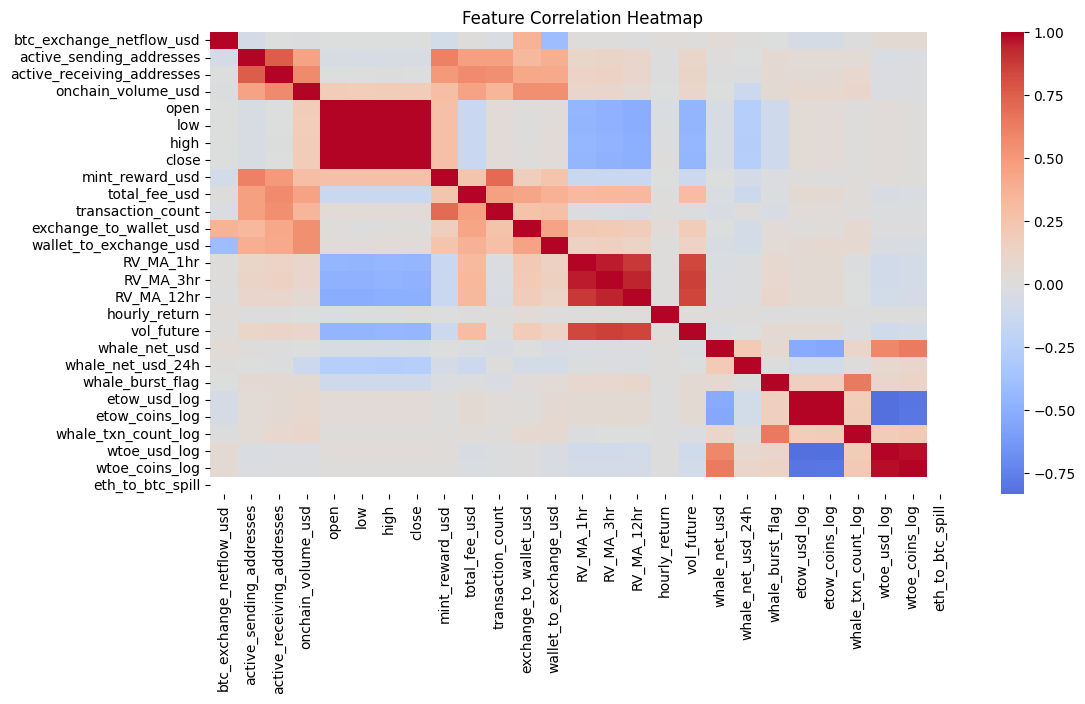

In [57]:
num_cols = btc_df.select_dtypes(include=np.number).columns
plt.figure(figsize=(12, 6))
sns.heatmap(btc_df[num_cols].corr(), cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.show()

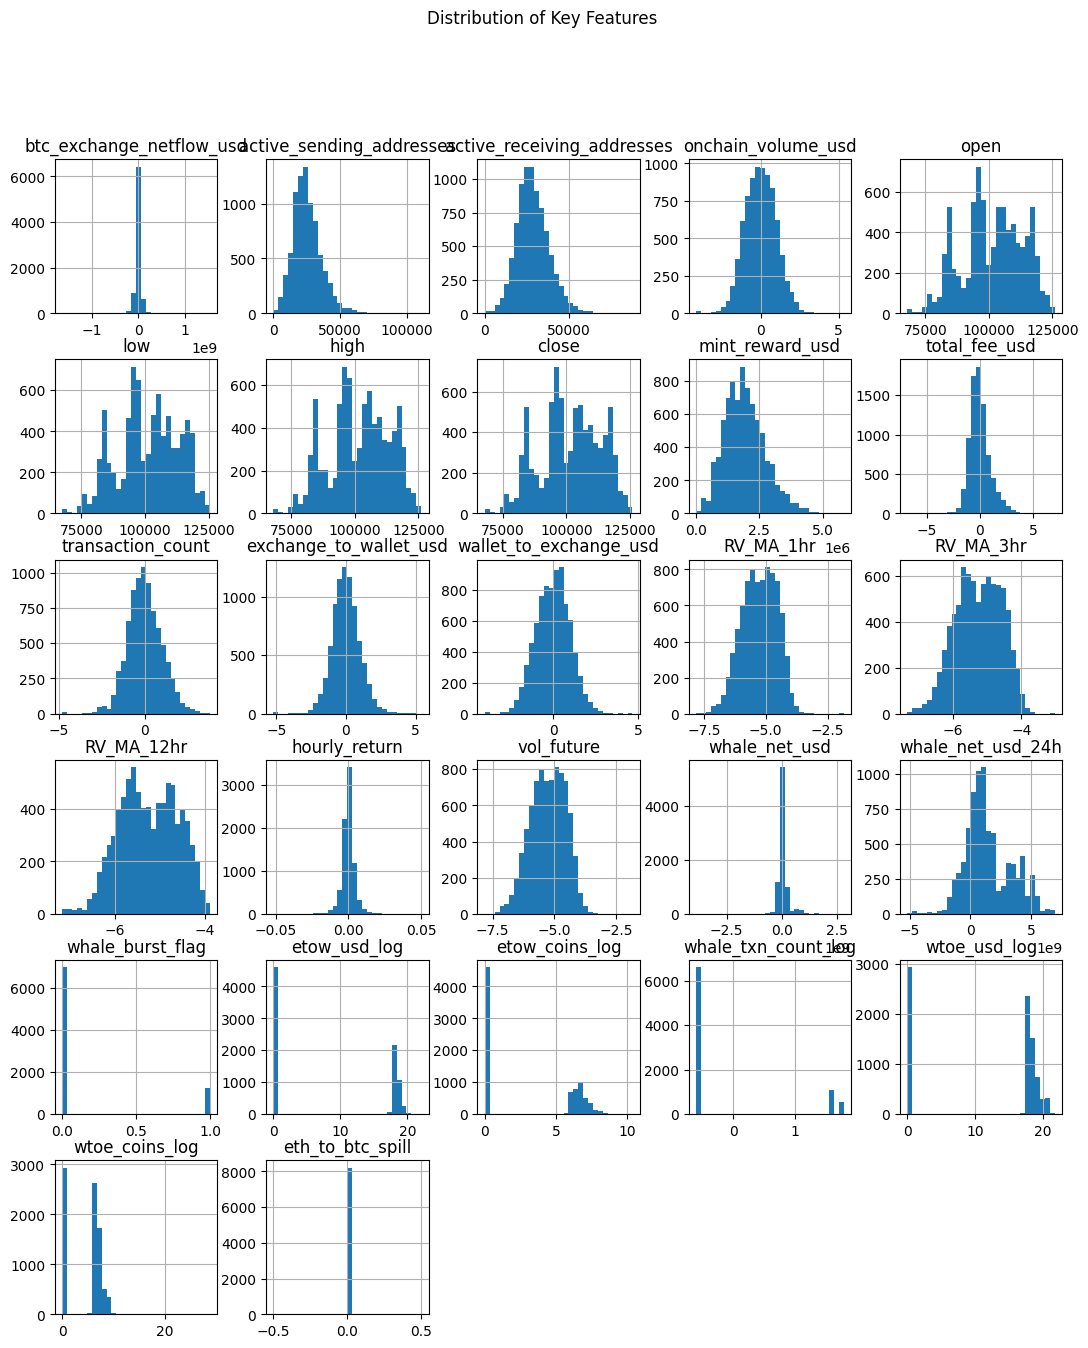

In [58]:
# Plot histograms for key numeric features
cols_to_plot = btc_df.columns
btc_df[cols_to_plot].hist(bins=30, figsize=(13, 15))
plt.suptitle("Distribution of Key Features")
plt.show()



Correlation with vol_future:
 vol_future                    1.000000
RV_MA_3hr                     0.857679
RV_MA_12hr                    0.844924
RV_MA_1hr                     0.841831
total_fee_usd                 0.309490
exchange_to_wallet_usd        0.191744
wallet_to_exchange_usd        0.131991
active_receiving_addresses    0.118234
active_sending_addresses      0.109552
onchain_volume_usd            0.091179
dtype: float64


/Users/ash/Documents/School/Y4S1/DSE4101/Project/DSE4101-CryptoWhale-2/.venv/lib/python3.14/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/ash/Documents/School/Y4S1/DSE4101/Project/DSE4101-CryptoWhale-2/.venv/lib/python3.14/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/var/folders/sr/m5w47sf11d525m54586gg3c00000gn/T/ipykernel_12672/1796175931.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr_target.values, y=corr_target.index, palette="viridis")


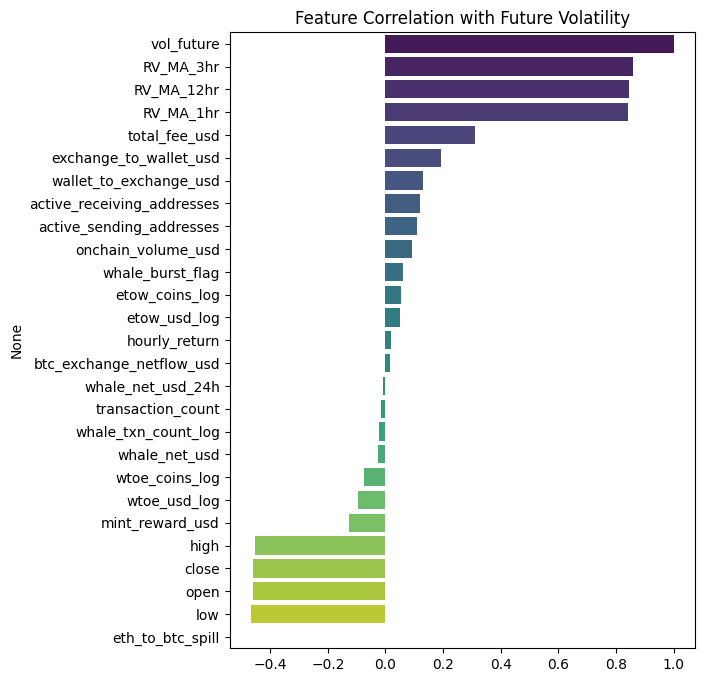

In [59]:
corr_target = btc_df[num_cols].corrwith(btc_df["vol_future"]).sort_values(ascending=False)
print("\nCorrelation with vol_future:\n", corr_target.head(10))

plt.figure(figsize=(6, 8))
sns.barplot(x=corr_target.values, y=corr_target.index, palette="viridis")
plt.title("Feature Correlation with Future Volatility")
plt.show()


### Volatility

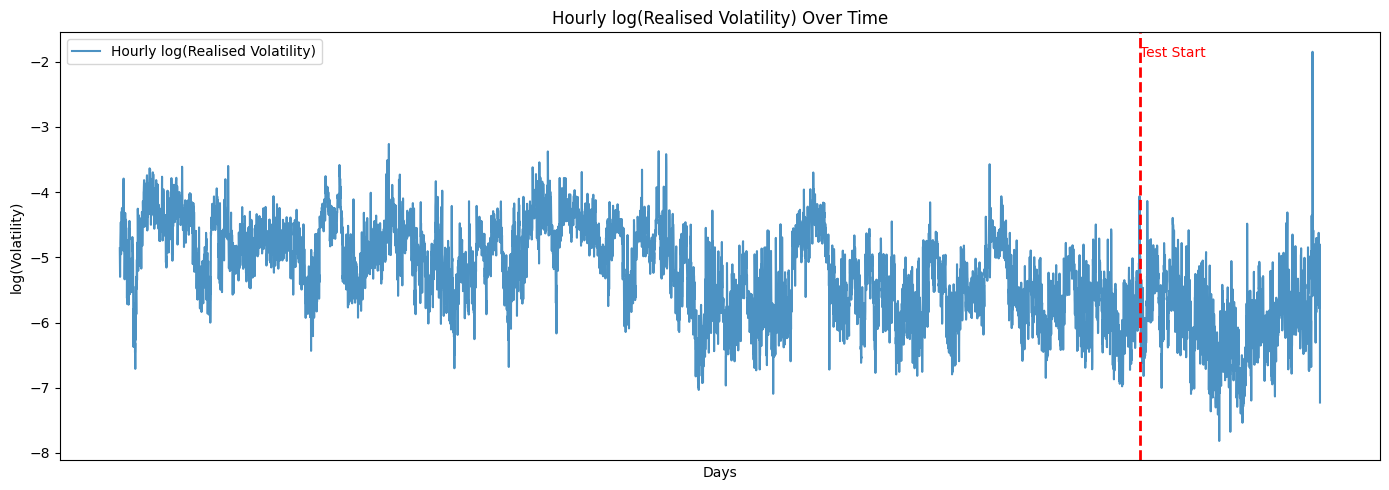

In [71]:
plt.figure(figsize=(14,5))
plt.plot(btc_df["timestamp"], btc_df["vol_future"], label="Hourly log(Realised Volatility)", alpha=0.8)
plt.title("Hourly log(Realised Volatility) Over Time")
plt.xlabel("Days")
plt.ylabel("log(Volatility)")
plt.legend()

# Vertical line for 85/15 split
split_idx = int(len(btc_df) * 0.85)
split_time = btc_df["timestamp"].iloc[split_idx]
plt.axvline(x=split_time, color="red", linestyle="--", linewidth=2, label="Train/Test Split")
plt.text(split_time, btc_df["vol_future"].max()*0.95, "Test Start", color="red", ha="left", va="top")

plt.xticks([])  # remove x-axis labels
plt.tight_layout()
plt.show()



In [61]:
btc_df.columns

Index(['timestamp', 'btc_exchange_netflow_usd', 'active_sending_addresses',
       'active_receiving_addresses', 'onchain_volume_usd', 'open', 'low',
       'high', 'close', 'mint_reward_usd', 'total_fee_usd',
       'transaction_count', 'exchange_to_wallet_usd', 'wallet_to_exchange_usd',
       'RV_MA_1hr', 'RV_MA_3hr', 'RV_MA_12hr', 'hourly_return', 'vol_future',
       'whale_net_usd', 'whale_net_usd_24h', 'whale_burst_flag',
       'etow_usd_log', 'etow_coins_log', 'whale_txn_count_log', 'wtoe_usd_log',
       'wtoe_coins_log', 'eth_to_btc_spill'],
      dtype='object')

### Whale

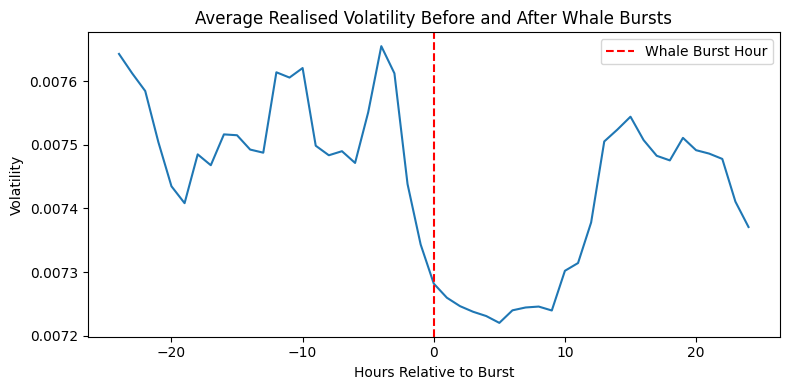

In [72]:
window = 24
segments = []

for idx in btc_df.index[btc_df["whale_burst_flag"] == 1]:
    if idx > window and idx + window < len(btc_df):
        seg = np.exp(btc_df["vol_future"].iloc[idx-window:idx+window+1])  # exponentiate here
        seg = seg.reset_index(drop=True)
        seg.index = range(-window, window+1)
        segments.append(seg)

avg_response = pd.concat(segments, axis=1).mean(axis=1)

plt.figure(figsize=(8,4))
plt.plot(avg_response.index, avg_response.values, color="tab:blue")
plt.axvline(0, color="red", linestyle="--", label="Whale Burst Hour")
plt.title("Average Realised Volatility Before and After Whale Bursts")
plt.xlabel("Hours Relative to Burst")
plt.ylabel("Volatility")
plt.legend()
plt.tight_layout()
plt.show()
